In [1]:
# 0. import library 필요한 라이브러리를 설치
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
plt.style.use("ggplot")

In [2]:
pd.set_option("display.max_columns",None)

In [163]:
# 0. read dataset 
# 데이터: 사내직원 인사평가데이터/적성검사데이터, 신입지원자 적성검사데이터
# 0.1 기준이 되는 데이터= 사내직원 인사평가데이터/적성검사데이터
# 목표변수: 사내직원 인사평가데이터 라벨 High, Middle, Low = 카테고리데이터(Ordinal)
# 설명변수: 사내직원 적성검사데이터 각 항목 점수 = 수치데이터(Continuous)

train=pd.read_excel("C:/local",encoding="cp932")

# 0.2 적용 대상 데이터; 신입지원자의 적성검사 데이터
test=pd.read_csv("C:/local",encoding="cp932")


In [152]:
# 1. dataset확인
# 결손치 확인 ; 아무 결과도 안나오면 결손치가 없다는 것
for i,n in enumerate(train.isnull().sum()):
    if n>0:print(i)
    elif n==0:pass
# 데이터타입확인 -> 카테고리데이터와 정수데이터를 정제 및 object타입의 밸류 확인
for i,a in enumerate(train.dtypes):
    if a=="object":
        print(train.iloc[:,i].value_counts())

M     277
LP     63
HP     51
Name: label, dtype: int64
A    302
B     83
C      6
Name: V57, dtype: int64


In [153]:
# 2．data cleansing 
# 필요한 변수만 남김
b=[0,1]+list(range(10,train.shape[1]))
train= train.iloc[:,b]
#수치화: 적성검사 항목점수는 전부 수치데이터이기 때문
train["V57"]=train["V57"].map(lambda x: 0 if x=="C" else 1 if x=="B" else 2) 
#Label Encoding: 평가데이터(Ordinal)를 수치데이터로 변환(회귀의 목표변수이므로)
train["label"]=train["label"].map(lambda x: 0 if x=="LP" else 1 if x=="M" else 2) 

[Text(0.5,1,'count per HP')]

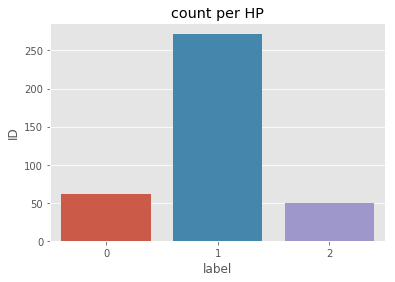

In [7]:
# 3．EDA
# EDA의 전반적인 결과, 현 데이터의 설명변수는 목표변수를 제대로 설명하지 못함

# 3．1목표변수의 히스토그램을 통해 분포를 확인
labelhist=train[["ID","label"]].groupby(["label"],as_index=False).agg(lambda x:len(x.value_counts())).sort_values(by="ID",ascending=False)
sns.barplot(data=labelhist,x="label",y="ID").set(title="count per HP")

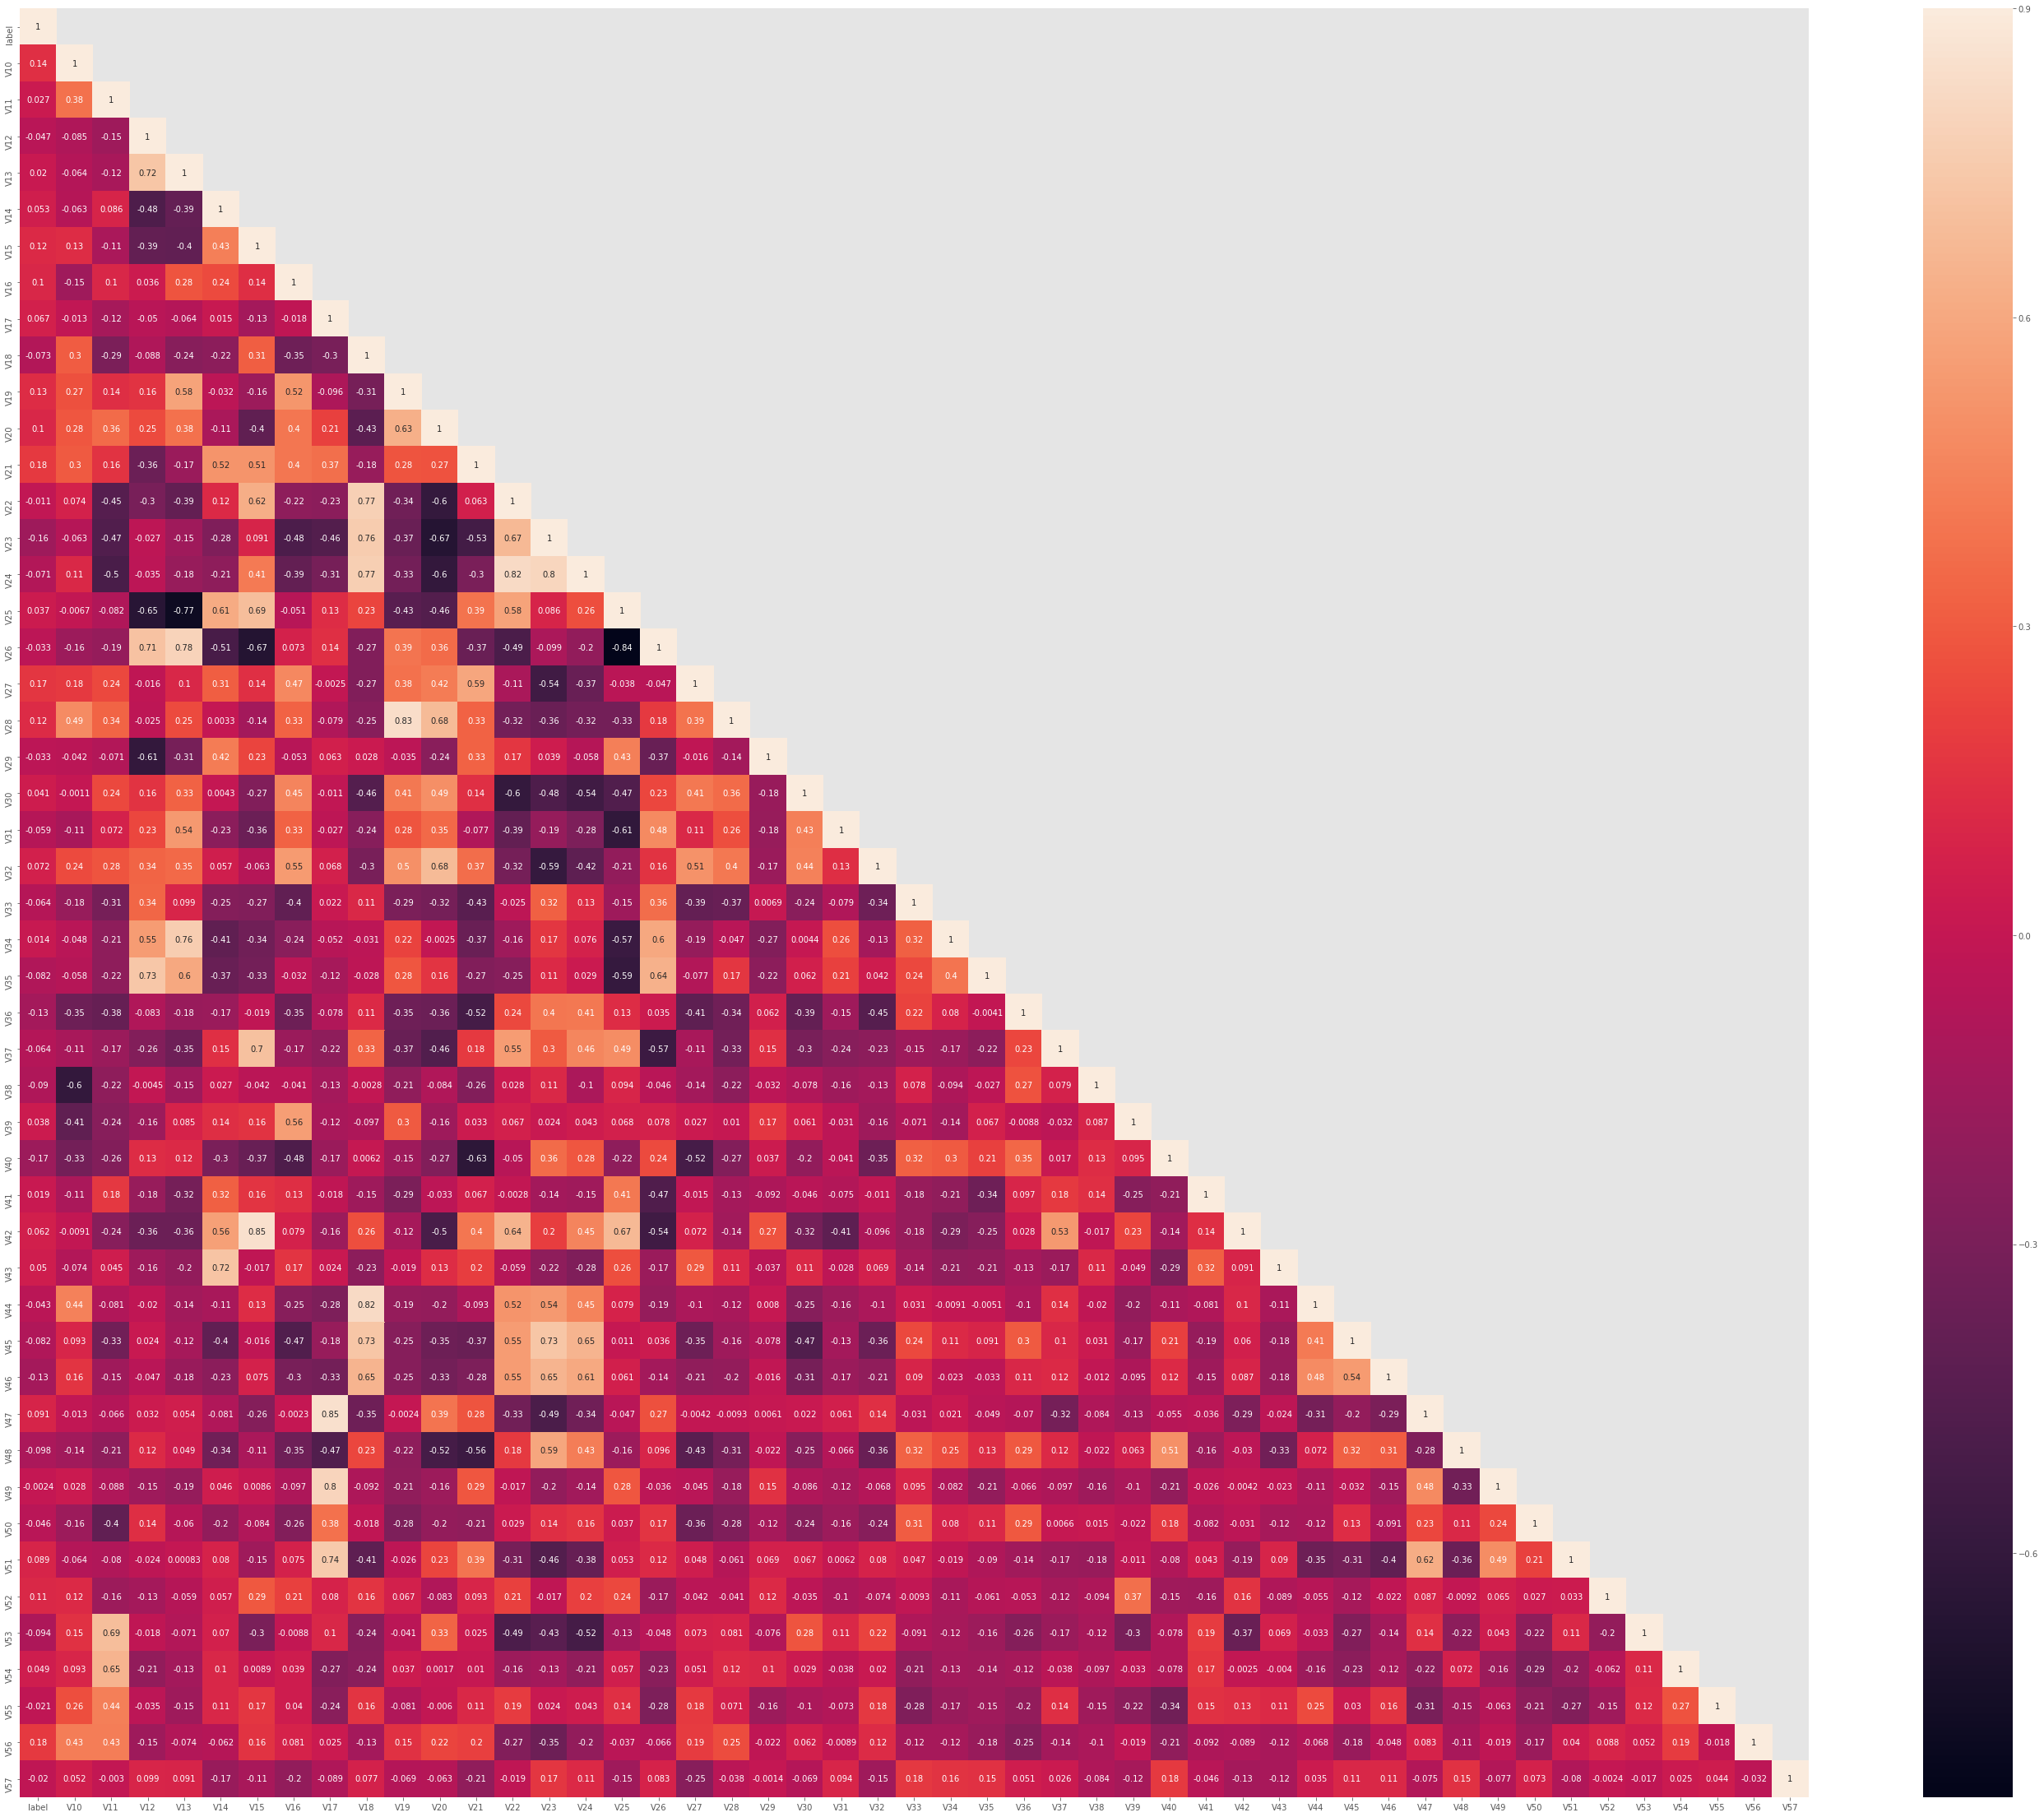

In [8]:
# 3．2 상관관계 -> 맨 및 라벨과의 상관관계가 있는 설명변수=적성검사 항목이 없음

#카테고리데이터는 카테고리화 
train["ID"]=pd.Categorical(train.ID)
traincorr=train.corr()
mask=np.array(traincorr)
mask[np.tril_indices_from(mask)]=False

fig,ax=plt.subplots()
fig.set_size_inches(50,40)
sns.heatmap(traincorr, mask=mask, vmax=.9, square=True, annot=True)

In [9]:
# 3．3 PCA를 활용한 클러스터 KMeans
#PCA를 활용하는 이유 -> 클러스터에 핵심인 변수만 추출 및 2d Plot을 통한 가시화
#[기존 목표변수와 PCA] vs [새로운 클러스터 변수와 PCA]　를 비교하여　현 데이터가 목표변수를 잘 분류하는지 확인

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1) 정규화
# 카테고리데이터와 목표변수는 제거 
train1=train.iloc[:,2:]
train_max = train1.max().max()
train_min = train1.min().min()

train_nm = (train1- train_min) / (train_max - train_min)
xn=train_nm.values

# 2)정규화된 데이터로, PCA를 계산 n_components를 결정
# 클러스터 결과 상 별다른 차이점이 없음 -> 2d그래프를 위해 PCA의 n_components=2 로 결정

# 2.1) n_components="mle"
pca = PCA(n_components="mle")
principalComponents = pca.fit_transform(xn)

# n_components="mle" 
principalDf = pd.DataFrame(data = principalComponents)
kmeansmle=KMeans(n_clusters=3).fit(principalDf)

# PCA와 클러스터의 데이터프레임생성 = [새로운 클러스터 변수와 PCA]
principalDf["c3"]=kmeansmle.labels_

# 2.2) n_components=2 for 2D
pca2 = PCA(n_components=2,svd_solver="randomized")
principalComponents2 = pca2.fit_transform(xn)
# n_components=2 2D
principalDf2 = pd.DataFrame(data = principalComponents2)
kmeans2=KMeans(n_clusters=3).fit(principalDf2)

# PCA와 클러스터의 데이터프레임생성 = [새로운 클러스터 변수와 PCA]
principalDf2["c3"]=kmeans2.labels_

# 2.3) n_components="mle" vs n_components=2 2D
print("n_components=mle",pca.explained_variance_ratio_)
print("n_components=2",pca2.explained_variance_ratio_)

display("n_components=mle",principalDf["c3"].value_counts())
display("n_components=2",principalDf2["c3"].value_counts())

n_components=mle [0.20272185 0.16407116 0.09478385 0.0694917  0.06680648 0.04474057
 0.03542584 0.02865557 0.0274401  0.02655365 0.02369033 0.02215189
 0.0195791  0.01769824 0.01586004 0.0139603  0.01352847 0.01326394
 0.01228139 0.0116344  0.00982618 0.00949676 0.00916945 0.0085638
 0.00760356 0.00663345 0.00639816 0.00567211 0.00451001 0.00135478
 0.00097011 0.00059598 0.00048901 0.00048501 0.00047401 0.0004017 ]
n_components=2 [0.20272185 0.16407116]


'n_components=mle'

2    151
1    150
0     90
Name: c3, dtype: int64

'n_components=2'

2    159
0    143
1     89
Name: c3, dtype: int64

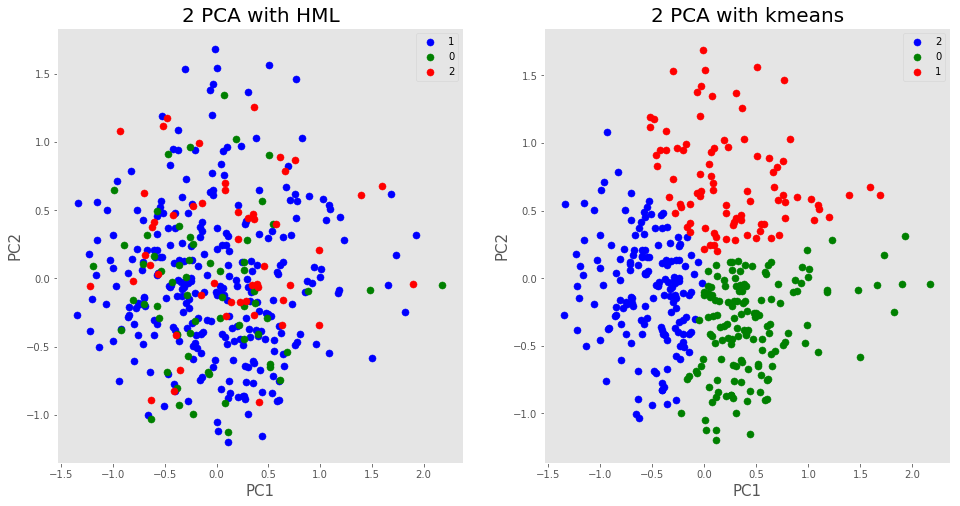

In [10]:
# 3) PCA와 목표변수의 데이터프레임생성 = [기존 목표변수와 PCA]
finalDf2 = pd.concat([principalDf2, train[["label"]]], axis = 1)

# 4) [기존 목표변수와 PCA] vs [새로운 클러스터 변수와 PCA]　를 비교
# 결과적으로 둘의 그래프가 다름-> 결과 상 현재 설명변수의 주성분분석이 라벨을 설명하지 못함
# 또한, 클러스터의 각 데이터가 상당히 밀접되어있어 제대로 된 분류가 불가능하다고 판단됨

fig = plt.figure(figsize = (16,8))

ax= fig.add_subplot(1,2,1)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 PCA with HML', fontsize = 20)

ax1= fig.add_subplot(1,2,2)
ax1.set_xlabel('PC1', fontsize = 15)
ax1.set_ylabel('PC2', fontsize = 15)
ax1.set_title('2 PCA with kmeans', fontsize = 20)

#2[기존 목표변수와 PCA] 
targets =finalDf2.label.unique()
colors = ['b', 'g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf2['label'] == target
    ax.scatter(finalDf2.loc[indicesToKeep, 0]
               , finalDf2.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#2  [새로운 클러스터 변수와 PCA]
targets1 =finalDf2.c3.unique()
colors1 = ['b', 'g', 'r']
for target, color in zip(targets1,colors1):
    indicesToKeep = finalDf2['c3'] == target
    ax1.scatter(finalDf2.loc[indicesToKeep, 0]
               , finalDf2.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax1.legend(targets1)
ax1.grid()

plt.show()

In [116]:
#  4．Feature Engineering
#  EDA의 전반적인 결과, 현 데이터의 설명변수는 목표변수를 제대로 설명하지 못함
#  따라서 회귀식과 가설검증을 통한 설명변수의 선별이 필요하다고 판단
# 4.1 ordinary least squares(OLS) -> Backward elimination for min AIC 
# 정보손실지표인 AIC가 최소가 되는 회귀식과 설명변수를 선별 

Names=[]
AIC=[]
Drop=[]
Features=[]
train1=train.drop(columns=["ID"],axis=1)
for i in train1.columns[1:]:
    if len(Drop)==0:
        names="+".join(train1.columns[1:])
        model=smf.ols(formula="label~"+names,data=train1)
        result=model.fit()
        Drop.append(i)
        Names.append(names)
        Features.append(train1.columns.values)
        AIC.append(result.aic)
    elif len(Drop)>0:
        traind=train1.drop(columns=Drop,axis=1)
        names="+".join(traind.columns[1:])
        model=smf.ols(formula="label~"+names,data=traind)
        result=model.fit()
        Drop.append(i)
        Names.append(names)
        Features.append(traind.columns.values)
        AIC.append(result.aic)
backAICdf=pd.DataFrame({"features":Features,"Name":Names,"AIC":AIC})
minAIC=backAICdf[backAICdf["AIC"]==min(backAICdf["AIC"])]

In [15]:
# 4.1 AIC 최소인 OLS로 회귀모델 구축 
# 하지만 회귀식 자체의 설명력은 낮음(조정된 결정계수:0.044 )
trainf=train1.loc[:,minAIC.features.values[0]]
modelf=smf.ols(formula="label~"+minAIC.Name.values[0],data=trainf)
resultf=modelf.fit()
display("OLS with minAIC",resultf.summary())

# 4.2 지수함수를 통해 1이 증가하면 긍정적인지 부정적인지를 파악 
#P값이 0.05이하 로만 추출
est=np.exp(resultf.params)
estp=100*(est-1).round(2)
Pv=resultf.pvalues
Namef=est.index.values
df_MS_=pd.DataFrame({"Name":Namef,"est":est,"estp":estp,"Pv":Pv})

df_MS_=df_MS_.iloc[1:,:]
df_MS_0=df_MS_[df_MS_.Pv<0.05]
display("result summary",df_MS_0)

# 4.3 선별된 변수로만 구성된 학습데이터(사내데이터)
cr=["label"]+list(df_MS_0.Name.values)
trainResult=trainf.loc[:,cr]


display("완성된 사내데이터",trainResult.head())

'OLS with minAIC'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     3.582
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           0.000951
Time:                        20:28:34   Log-Likelihood:                -300.82
No. Observations:                 391   AIC:                             617.6
Df Residuals:                     383   BIC:                             649.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4807      0.206      2.333      0.020       0.076       0.886
V51            0.0307      0.015      2.012      0.045       0.001       0.061
V52            0.0206      0.013      1.533      0.126      -0.006       0.047
V53           -0.0283      0.014     -2.068      0.039      -0.055      -0.001
V54            0.0128      0.014      0.940      0.348      -0.014       0.040
V55            0.0054      0.014      0.400      0.689      -0.021       0.032
V56            0.0464      0.014      3.313      0.001       0.019       0.074
V57           -0.0110      0.058     -0.190      0.849      -0.125       0.103
==============================================================================
Omnibus:                        3.207   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                3.077
Skew:                          -0.144   Prob(JB):                        0.215
Kurtosis:                       3.325   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'result summary'

,Name,est,estp,Pv
V51,V51,1.031158,3.0,0.044904
V53,V53,0.972089,-3.0,0.039335
V56,V56,1.047462,5.0,0.001010


'완성된 사내데이터'

,label,V51,V53,V56
0,1,4,5,6
1,1,3,5,7
2,0,3,6,5
3,1,3,6,3
4,1,5,3,9


In [193]:
# 5.분류Classification: 선별된 변수로만 구성된 학습데이터(=사내데이터)로 분류진행

# 5.1 기계학습: split train set, test set
x=trainResult.drop(columns=["label"])
y=trainResult.label
#표준화
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_scaled= sc.fit_transform(x)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.3)

# 5.2 기계학습: 데이터셋이 적기 때문에 과적합을 방지하기 위해 앙상블 라이브러리를 적용
#랜덤포레스트
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_predRF = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)

#AdaBoost
from sklearn.ensemble import AdaBoostClassifier
AdaBoost =  AdaBoostClassifier(n_estimators=100)
AdaBoost.fit(X_train, y_train)
Y_predAda = AdaBoost.predict(X_test)
acc_AdaBoost = round(AdaBoost.score(X_train, y_train) * 100, 2)

#GBM
from sklearn.ensemble import GradientBoostingClassifier
GBM = GradientBoostingClassifier(n_estimators=100)
GBM.fit(X_train, y_train)
Y_predGBM = GBM.predict(X_test)
acc_GBM=round(GBM.score(X_train, y_train)*100, 2)

#각 모델의 성능(accuracy)를 비교
# 결과적으로 랜덤포레스트의 성능이 좋음 
from sklearn.metrics import accuracy_score

models = pd.DataFrame({'Model': ['RandomForest', 'AdaBoost', 'GBM'],
    'Score': [acc_random_forest, acc_AdaBoost, acc_GBM]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,RandomForest,87.55
2,GBM,79.85
1,AdaBoost,67.40


In [278]:
# 5.1 분류;매칭도= 각 평가 별 유클리디안 거리

# 앙상블 기계학습과 더불어 유클리디안 거리를 계산 
#각 평가별 유클리디안 거리 중 짧은 거리의 평가가 지원자의 평가결과가 될 가능성이 큼
#데이터셋이 적어 아웃라이어의 영향을 피하기 위해, 유클리디안 거리의 대표치를 중앙치로 설정
def smallest(num1, num2, num3):
    if (num1 < num2) and (num1 < num3):
        return num1
    elif (num2 < num1) and (num2 < num3):
        return num2
    else:
        return num3

# 5.1.1 사내 데이터의 중앙치

#ols의 결과를 활용
feature=list(df_MS_0.Name.values)
#각 평가별로 데이터셋을 구분
th=trainResult[trainResult.label==2]
tm=trainResult[trainResult.label==1]
tl=trainResult[trainResult.label==0]

th_med=np.array(th[feature].median()) 
tm_med=np.array(tm[feature].median()) 
tl_med=np.array(tl[feature].median())

# 5.1.2 ols를 통해 필요한 변수만 선별한 신입지원자의 데이터
es=test[feature]

#5.1.3 각 평가별 유클리디안 거리를 계산 후 라벨 분류
es_th=[]
es_tm=[]
es_tl=[]
es_label=[]

for i in range(es.shape[0]):
    h=np.linalg.norm(np.array(es.iloc[i,:])-th_med)
    m=np.linalg.norm(np.array(es.iloc[i,:])-tm_med)
    l=np.linalg.norm(np.array(es.iloc[i,:])-tl_med)
    if smallest(h,m,l)==h:
        lab="H"
    elif smallest(h,m,l)==m:
        lab="M"
    elif smallest(h,m,l)==l:
        lab="L"
    else: lab="X"
    es_th.append(h)
    es_tm.append(m) 
    es_tl.append(l) 
    es_label.append(lab)
    
eshml=pd.DataFrame({"h":es_th,"m":es_tm,"l":es_tl,"label":es_label})

# 지원자 데이터를 완성
testR=pd.concat([test1["ID"],es,eshml],axis=1)
display(testR.head())

,ID,V51,V53,V56,h,m,l,label
0,0,6.0,7.0,5.0,3.316625,3.162278,3.605551,M
1,1,5.0,3.0,4.0,2.236068,1.414214,1.732051,M
2,2,6.0,4.0,1.0,5.099020,4.123106,4.472136,M
3,3,4.0,1.0,2.0,5.099020,4.358899,4.242641,L
4,4,4.0,5.0,7.0,1.732051,2.449490,2.236068,H


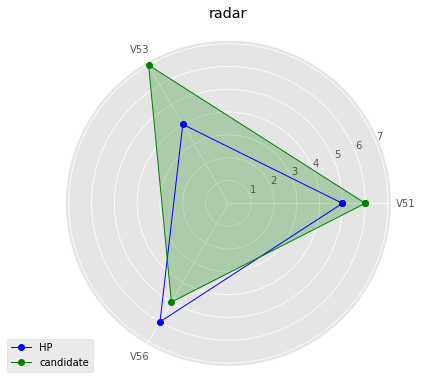

In [272]:
# 6. 위의 결과를 바탕으로 차트 작성
# 유저입장에서 지원자 ID를 검색하면 각 매칭도와 분류, 그래프가 나올 수 있도록
# 6.1 그래프=레이더차트
labels=feature
#기준치: 사내직원의 높은 평가데이터에 대해,  ols결과 및 중앙치를 활용
th= pd.DataFrame({"val":th_med},index=feature)
tr1=np.concatenate((th.values,[th.values[0]]))

#비교치: 지원자데이터에 대해, ols결과를 활용
testR0=testR[testR["ID"]==0]
val=testR0[feature].values[0]
testR0m=pd.DataFrame({"val":val},index=feature)
es0=np.concatenate((testR0m.values,[testR0m.values[0]]))

# create backgroud radar chart
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))

fig=plt.figure()
ax= fig.add_subplot(111, polar=True)
fig.set_size_inches(6,6)
ax.set_title("radar")


# 기준치(사내데이터) radar chart 
ax.plot(angles, tr1, 'o-', linewidth=1,label="HP",color="b")
ax.set_thetagrids(angles * 180/np.pi, labels)

# 지원자 radar chart 
ax.plot(angles,es0, 'o-', linewidth=1,label="candidate",color="green")
ax.fill(angles,es0,"green",alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)
plt.legend(loc="upper right",bbox_to_anchor=(0.1,0.1))
